In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup          # BeautifulSoup is a useful library for extracting data from HTML and XML documents
from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Dense, Embedding, LSTM, GRU
import pandas.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

# Load the Dataset
movie_reviews = pd.read_csv("/content/IMDB Dataset.csv")

In [ ]:

# Check the shape of the data
movie_reviews.shape

(50000, 2)

In [ ]:

movie_reviews.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [ ]:

# Check for null Values
movie_reviews.isnull().sum()


review       0
sentiment    0
dtype: int64

In [ ]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

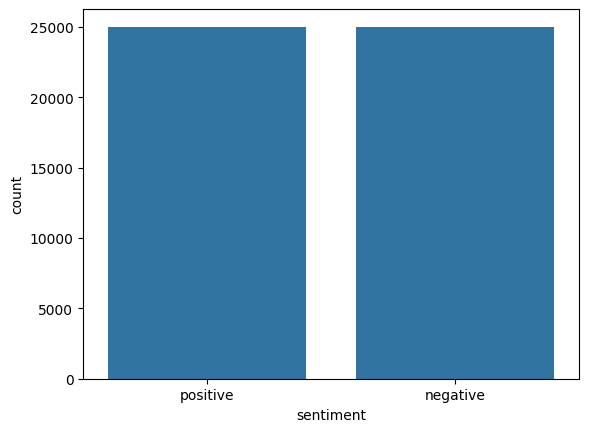

In [ ]:
# View the distribution of positive and negative sentiments in the dataset
sns.countplot(x='sentiment', data = movie_reviews)
plt.show()


In [ ]:
# removing the html strips
def strip_html(text):
    # BeautifulSoup is a useful library for extracting data from HTML and XML documents
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [ ]:

movie_reviews['review'] = movie_reviews['review'].apply(strip_html)

In [ ]:
# removing punctuations
def remove_punctuations(text):

    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text


In [ ]:

# Remove puntuations
movie_reviews['review'] = movie_reviews['review'].apply(remove_punctuations)

In [ ]:
# setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)


['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [ ]:

# Exclude 'not' and its other forms from the stopwords list

updated_stopword_list = []

for word in stopword_list:
    if word=='not' or word.endswith("n't"):
        pass
    else:
        updated_stopword_list.append(word)

print(updated_stopword_list)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', 'd', 'did', 'didn', 'do', 'does', 'doesn', 'doing', 'don', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', 'has', 'hasn', 'have', 'haven', 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', 'more', 'most', 'mustn', 'my', 'myself', 'needn', 'no', 'nor', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', 'she', "she'd", "she'll", "she's", 'should', 'shouldn', "should've", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'their', 'theirs'

In [ ]:
pip install nltk


In [ ]:
import nltk


In [ ]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> punkt_tab


      Package punkt_tab is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [ ]:

from nltk.tokenize import word_tokenize
print(word_tokenize("This is a test."))  # Should work now

['This', 'is', 'a', 'test', '.']


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download required resources
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered)

# Apply to your DataFrame
movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# # Import the NLTK library
# import nltk

# # Download the 'punkt_tab' resource
# nltk.download('punkt_tab')

# # setting english stopwords
# stopword_list = nltk.corpus.stopwords.words('english')
# print(stopword_list)

# # Exclude 'not' and its other forms from the stopwords list
# updated_stopword_list = []

# for word in stopword_list:
#     if word=='not' or word.endswith("n't"):
#         pass
#     else:
#         updated_stopword_list.append(word)

# print(updated_stopword_list)

# # removing the stopwords
# def remove_stopwords(text, is_lower_case=False):
#     # splitting strings into tokens (list of words)
#     tokens = nltk.tokenize.word_tokenize(text)
#     tokens = [token.strip() for token in tokens]
#     if is_lower_case:
#         # filtering out the stop words
#         filtered_tokens = [token for token in tokens if token not in updated_stopword_list]
#     else:
#         filtered_tokens = [token for token in tokens if token.lower() not in updated_stopword_list]
#     filtered_text = ' '.join(filtered_tokens)
#     return filtered_text

# # Apply function on review column
# movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)


In [ ]:
movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)

In [ ]:
movie_reviews.head()

review sentiment
0  One reviewers mentioned watching 1 Oz episode ...  positive
1  wonderful little production filming technique ...  positive
2  thought wonderful way spend time hot summer we...  positive
3  Basically theres family little boy Jake thinks...  negative
4  Petter Matteis Love Time Money visually stunni...  positive

In [ ]:
# Convert sentiment labels to integers

movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x=="positive" else 0)

In [ ]:

movie_reviews.head()

review  sentiment
0  One reviewers mentioned watching 1 Oz episode ...          1
1  wonderful little production filming technique ...          1
2  thought wonderful way spend time hot summer we...          1
3  Basically theres family little boy Jake thinks...          0
4  Petter Matteis Love Time Money visually stunni...          1

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['review'].values, movie_reviews['sentiment'].values,
                                                    test_size=0.20,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(40000, 10000, 40000, 10000)

In [ ]:

# Tokenizer class from the keras.preprocessing.text module creates a word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)


In [ ]:

# Find the vocabulary size and perform padding on both train and test set
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_pad = pad_sequences(X_train_tok, padding='post', maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test_tok, padding='post', maxlen=maxlen, truncating='post')

In [ ]:

print ('number of unique words in the corpus:', vocab_size)

number of unique words in the corpus: 192115


In [ ]:

EMBEDDING_DIM = 32

print('Build model...')

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:

history = model.fit(X_train_pad, y_train, batch_size=128, epochs=1, verbose=1, validation_split=0.2)

250/250 ━━━━━━━━━━━━━━━━━━━━ 137s 525ms/step - accuracy: 0.5810 - loss: 0.6519 - val_accuracy: 0.7686 - val_loss: 0.5410


In [ ]:

print('Testing...')
y_test = np.array(y_test)
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - accuracy: 0.7684 - loss: 0.5412
Test score: 0.5371435880661011
Test accuracy: 0.7721999883651733
Accuracy: 77.22%


In [ ]:
#Let us test some  samples
test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "Not to my taste, will skip and watch another movie"
test_sample_5 = "if you like action, then this movie might be good for you."
test_sample_6 = "Bad movie!"
test_sample_7 = "Not a good movie!"
test_sample_8 = "This movie really sucks! Can I get my money back please?"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8]

test_samples_tokens = tokenizer.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=maxlen)

# predict
pred = model.predict(x=test_samples_tokens_pad)
pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step


array([[0.77566385],
       [0.771477  ],
       [0.7736679 ],
       [0.77615076],
       [0.776268  ],
       [0.77237254],
       [0.771477  ],
       [0.77723414]], dtype=float32)

In [ ]:
!pip install shap
!pip install lime
!pip install eli5
!pip install alibi

In [ ]:
import lime
import lime.lime_text
import numpy as np

# Assuming model and X_test are ready from before

# Create a LimeTextExplainer
# The class_names should match your model's output classes (0 for negative, 1 for positive)
explainer = lime.lime_text.LimeTextExplainer(class_names=['Negative', 'Positive'])

# Define a prediction function that Lime can use
# Lime expects a function that takes a list of strings and returns probabilities for each class
def predict_proba_for_lime(text_list):
    # Tokenize and pad the text list
    text_tokens = tokenizer.texts_to_sequences(text_list)
    text_pad = pad_sequences(text_tokens, maxlen=maxlen)
    # Get predictions from the model
    predictions = model.predict(text_pad)
    # Lime expects probabilities for each class. Since your model outputs a single value (sigmoid),
    # we need to create a 2D array where the second column is 1 - prediction.
    # This represents the probability for the negative class.
    return np.hstack((1 - predictions, predictions))

# Explain the first test instance (using the original text before tokenization/padding)
i = 0
# Get the original review text from X_test (which is still a NumPy array of strings)
original_text_to_explain = X_test[i]

exp = explainer.explain_instance(
    text_instance=original_text_to_explain,
    classifier_fn=predict_proba_for_lime,
    num_features=5 # Number of features (words) to highlight in the explanation
)

# Show explanation
# Removed the 'show_table=True' argument
exp.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step
